In [1]:
# Import helper functions
from tools import load_config, load_excel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from drug_data import typo_corrections, drug_categories
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances


# Load configuration
config = load_config("config.yaml")

# Extract variables
data_location = config["data_location"]

# Load data
data = load_excel(data_location)

c:\Users\Danylo\Desktop\MainCategories\MastersDiploma\Practice\program\src\config.yaml


In [2]:
data.head()

,No,Sex,"Вік, років",Age1 (m),Age2 (d),Weight,Height,Vomiting,Freq. min,Freq. max,...,ORS type,Inf,Infus type (name),Z,Препарат цинку,AD,Adtype,AB,Name of antibiotic,Кількість ліжко-днів
0,1,2,0,4,22,4.9,60.0,1,2.0,3.0,...,New oralit,Yes,RL,Y,Zinckid,N,NaN,NaN,NaN,3
1,2,1,1,10,22,6.4,69.0,1,3.0,4.0,...,New oralit,Yes,RL,Y,Zinckid,N,NaN,NaN,NaN,3
2,3,1,1,10,13,13.0,82.0,2,NaN,NaN,...,New oralit,Yes,RL,Y,Zinckid,N,NaN,NaN,NaN,5
3,4,2,0,7,27,7.0,65.0,1,2.0,3.0,...,New oralit,Yes,RL,Y,Zinckid,Y,"Paracetamol 3x1/2 cth (if 57,38,5 C)",N,NaN,2
4,5,1,1,2,15,8.3,68.0,2,NaN,NaN,...,New oralit,Yes,others,Y,zincjid,Y,"Paracetamol 3xcm I_x000D_\nDiaxepam 2,5mg if c...",Y,Cefixim simp,3


In [3]:
data.columns

Index(['No', 'Sex', 'Вік, років', 'Age1 (m)', 'Age2 (d)', 'Weight', 'Height',
       'Vomiting', 'Freq. min', 'Freq.  max', 'Temperature', 'Dehydration',
       'Ротавірус', 'ORS', 'ORS type', 'Inf', 'Infus type (name)', 'Z',
       'Препарат цинку', 'AD', 'Adtype', 'AB', 'Name of antibiotic',
       'Кількість ліжко-днів'],
      dtype='object')

In [4]:
len(data)

840

In [5]:
from tools import load_config

# Attempt to load the configuration
try:
    config = load_config("config.yaml")
    print("Config loaded successfully!")
    print(config)
except FileNotFoundError as e:
    print(f"File not found: {e}")
except RuntimeError as e:
    print(f"YAML Error: {e}")

Config loaded successfully!
{'data_location': 'data/rotavirus_data.xlsx', 'processed_data_location': 'data/saved_data.csv'}


In [6]:
# Renaming columns to shorter names
short_renamed_columns = {
    'No': 'subjid',
    'Sex': 'sex',
    'Вік, років': 'agey',
    'Age1 (m)': 'agem',
    'Age2 (d)': 'aged',
    'Weight': 'weight',
    'Height': 'height',
    'Vomiting': 'vomitfl',
    'Freq. min': 'vomit_minfrq',
    'Freq.  max': 'vomit_maxfrq',
    'ORS': 'orsfl',
    'ORS type': 'orstype',
    'Inf': 'inffl',
    'Infus type (name)': 'inftype',
    'Z': 'zincfl',
    'Препарат цинку': 'ztype',
    'AD': 'adrug',
    'Adtype': 'adrugtype',
    'AB': 'antibfl',
    'Name of antibiotic': 'antibtype',
    'Кількість ліжко-днів': 'hosp_days',
    'Ротавірус': 'virusfl',
    'Temperature': 'temp',
    "Dehydration": 'dehsev'
}

# Apply the renaming
data.rename(columns=short_renamed_columns, inplace=True)

# Display the first few rows to verify
print(data.head())


   subjid  sex  agey  agem  aged  weight  height  vomitfl  vomit_minfrq  \
0       1    2     0     4    22     4.9    60.0        1           2.0   
1       2    1     1    10    22     6.4    69.0        1           3.0   
2       3    1     1    10    13    13.0    82.0        2           NaN   
3       4    2     0     7    27     7.0    65.0        1           2.0   
4       5    1     1     2    15     8.3    68.0        2           NaN   

   vomit_maxfrq  ...     orstype inffl inftype zincfl    ztype adrug  \
0           3.0  ...  New oralit   Yes      RL      Y  Zinckid     N   
1           4.0  ...  New oralit   Yes      RL      Y  Zinckid     N   
2           NaN  ...  New oralit   Yes      RL      Y  Zinckid     N   
3           3.0  ...  New oralit   Yes      RL      Y  Zinckid     Y   
4           NaN  ...  New oralit   Yes  others      Y  zincjid     Y   

                                           adrugtype antibfl     antibtype  \
0                                     

In [7]:
# Function to recode FL columns
def recode_fl_columns(df):
    # Identify all columns ending with 'fl'
    fl_columns = [col for col in df.columns if col.endswith('fl')]
    for col in fl_columns:
        df[col] = df[col].apply(lambda x: 1 if str(x).strip().lower() in ['yes', 'y', 'true', '1'] else 0)
    return df

# Apply the function to recode FL columns
data = recode_fl_columns(data)

# Display the first few rows to verify
print(data.head())


   subjid  sex  agey  agem  aged  weight  height  vomitfl  vomit_minfrq  \
0       1    2     0     4    22     4.9    60.0        1           2.0   
1       2    1     1    10    22     6.4    69.0        1           3.0   
2       3    1     1    10    13    13.0    82.0        0           NaN   
3       4    2     0     7    27     7.0    65.0        1           2.0   
4       5    1     1     2    15     8.3    68.0        0           NaN   

   vomit_maxfrq  ...     orstype inffl  inftype  zincfl    ztype  adrug  \
0           3.0  ...  New oralit     1       RL       1  Zinckid      N   
1           4.0  ...  New oralit     1       RL       1  Zinckid      N   
2           NaN  ...  New oralit     1       RL       1  Zinckid      N   
3           3.0  ...  New oralit     1       RL       1  Zinckid      Y   
4           NaN  ...  New oralit     1   others       1  zincjid      Y   

                                           adrugtype  antibfl     antibtype  \
0                  

In [8]:
unique_values = data['dehsev'].unique()
unique_values


array(['Severe dehydration', 'Mild dehydration', 'No dehydration', nan],
      dtype=object)

In [9]:
# Count the number of NaN values in 'dehsev'
nan_count = data['dehsev'].isna().sum()

# Display the count
print(f"Number of NaN values in 'dehsev': {nan_count}")


Number of NaN values in 'dehsev': 4


In [10]:
data[data['dehsev'].isna()]

,subjid,sex,agey,agem,aged,weight,height,vomitfl,vomit_minfrq,vomit_maxfrq,...,orstype,inffl,inftype,zincfl,ztype,adrug,adrugtype,antibfl,antibtype,hosp_days
708,850,2,0,2,14,2.5,50.0,1,1.0,2.0,...,Oralit,1,KaEN,1,Zinckid,Y,Cefotaxim _x000D_\nGentamicin _x000D_\nSanmol ...,0,NaN,33
759,902,1,0,11,1,9.5,87.0,0,NaN,NaN,...,NaN,0,NaN,0,NaN,N,NaN,0,NaN,2
761,904,1,1,5,28,10.0,71.0,0,NaN,NaN,...,NaN,0,NaN,1,Zinckid,Y,Ampicilin_x000D_\nClirolanfenicol_x000D_\nDiam...,0,NaN,10
781,924,1,1,3,0,6.2,62.0,1,1.0,3.0,...,New oralit,0,NaN,0,NaN,Y,Ceftriaxone 2x300mg,0,NaN,9


In [11]:
print(f"Rows before dropping NaN: {len(data)}")

# Drop rows with NaN in 'dehsev'
data = data.dropna(subset=['dehsev'])

# Verify that the rows were dropped
print(f"Remaining rows after dropping NaN: {len(data)}")


Rows before dropping NaN: 840
Remaining rows after dropping NaN: 836


In [12]:
# Check unique values in the 'adrugtype' column
unique_adrugtype = data['adrugtype'].unique()
print(unique_adrugtype)

[nan 'Paracetamol 3x1/2 cth (if 57,38,5 C)'
 'Paracetamol 3xcm I_x000D_\nDiaxepam 2,5mg if convulsions_x000D_\nCefotaxim 4x400mg'
 'Probiotik' 'Dialac 3x1 sachet_x000D_\nParacetamol 3x1_x000D_\n'
 'koreksi kel 7.46% 30 mg dlm 1000ml_x000D_\nRL 24_x000D_\nKce Pulws 3x275mg po'
 'Domperidon _x000D_\nParacetamol_x000D_\n'
 'cloramfenicol_x000D_\nampicillin_x000D_\n' 'Kci pulvus 3x250 mg po'
 'domperidon syr 3xcm1/2' 'AB: Ampicillin_x000D_\ngentamicyn'
 'Ampicillin 4x250 g N_x000D_\nCefotaxime 3x250 g N' 'Ambroxce syr'
 'Cotrimoxazole 2x1 cth' 'Ampicillin 4x150g' 'Cotrimoxazole 2x15 I'
 'Ampicillin' 'Ampicillin IV'
 'cefotaxime_x000D_\nbolus RL_x000D_\nparacetamol' 'Probiotil 1x1 sachet'
 'parascetamol_x000D_\n' 'cotrimoxazole_x000D_\nmetromidazole'
 'paracetamol 3x1/2cg_x000D_\nprobiotik' 'parasetamol 3xcg I'
 'parasetamol' 'lacto B_x000D_\n' 'cerobxum' 'ampicilin'
 'ampicilin 4x800_x000D_\ncerobxum 3x800' 'paracetamol syr'
 'Rehidrasi dg Resomal_x000D_\nAmpicillin 4x300mg IV_x000D_\nGent

In [13]:
# Clean the 'adrugtype' column
data['adrugtype'] = data['adrugtype'].str.replace('_x000D_', '', regex=False)
data['adrugtype'] = data['adrugtype'].str.replace('\n', ' ', regex=False)
data['adrugtype'] = data['adrugtype'].str.strip()  # Remove leading/trailing spaces


In [14]:
# Print unique values in 'adrugtype'
unique_adrugtype = data['adrugtype'].unique()
print(unique_adrugtype)


[nan 'Paracetamol 3x1/2 cth (if 57,38,5 C)'
 'Paracetamol 3xcm I Diaxepam 2,5mg if convulsions Cefotaxim 4x400mg'
 'Probiotik' 'Dialac 3x1 sachet Paracetamol 3x1'
 'koreksi kel 7.46% 30 mg dlm 1000ml RL 24 Kce Pulws 3x275mg po'
 'Domperidon  Paracetamol' 'cloramfenicol ampicillin'
 'Kci pulvus 3x250 mg po' 'domperidon syr 3xcm1/2'
 'AB: Ampicillin gentamicyn' 'Ampicillin 4x250 g N Cefotaxime 3x250 g N'
 'Ambroxce syr' 'Cotrimoxazole 2x1 cth' 'Ampicillin 4x150g'
 'Cotrimoxazole 2x15 I' 'Ampicillin' 'Ampicillin IV'
 'cefotaxime bolus RL paracetamol' 'Probiotil 1x1 sachet' 'parascetamol'
 'cotrimoxazole metromidazole' 'paracetamol 3x1/2cg probiotik'
 'parasetamol 3xcg I' 'parasetamol' 'lacto B' 'cerobxum' 'ampicilin'
 'ampicilin 4x800 cerobxum 3x800' 'paracetamol syr'
 'Rehidrasi dg Resomal Ampicillin 4x300mg IV Gentamicin 1x50 mg IV Vit A 200000 IV Vit C 1x1, As Folat 1x5mg hari I'
 'Paracetamol syrup 3x1/2 cth' 'Kotri 2xcth II p.o'
 'Paracetamol syr 3x1 cth' '02 21lm Diazepam supp 10mg'

In [15]:
import re

# Assuming 'data' is your DataFrame with the 'adrugtype' column
# Uncomment and modify the following line if you need to load your data from a CSV file
# data = pd.read_csv('your_data.csv')  # Replace 'your_data.csv' with your actual file name

# Step 1: Define Typo Corrections and Drug Categories


def clean_text(text):
    """
    Clean the input text by converting to lowercase, removing special characters,
    and normalizing whitespace.
    """
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)  # Remove special characters except letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space
    return text

def correct_typos(text):
    """
    Correct common typos and variations in drug names using the typo_corrections dictionary.
    """
    words = text.split()
    corrected_words = []
    i = 0
    while i < len(words):
        word = words[i]
        # Check for two-word drugs
        if i < len(words) - 1:
            two_word = f"{words[i]} {words[i + 1]}"
            if two_word in typo_corrections:
                corrected_words.append(typo_corrections[two_word])
                i += 2
                continue
        # Correct single-word typos
        corrected_word = typo_corrections.get(word, word)
        corrected_words.append(corrected_word)
        i += 1
    return ' '.join(corrected_words)

# Create a set of all drug names for matching
drug_names = set(drug_categories.keys())

def extract_drugs(text):
    """
    Extract drug names from the input text by matching words against known drug names.
    Handles both single-word and two-word drug names.
    """
    found_drugs = set()
    words = text.split()
    i = 0
    while i < len(words):
        word = words[i]
        # Check for two-word drug names
        if i < len(words) - 1:
            two_word = f"{words[i]} {words[i + 1]}"
            if two_word in drug_names:
                found_drugs.add(two_word)
                i += 2
                continue
        # Check for single-word drug names
        if word in drug_names:
            found_drugs.add(word)
        i += 1
    return list(found_drugs)

def map_drugs_to_categories(drugs):
    """
    Map each drug in the list to its corresponding category.
    """
    categories = set()
    for drug in drugs:
        category = drug_categories.get(drug)
        if category:
            categories.add(category)
    return list(categories)

def process_categories(data):
    # Initialize an empty list to store the drug categories for each row
    drug_categories_list = []

    for _, row in data.iterrows():
        # Clean and process the 'adrugtype' column
        cleaned_text = clean_text(row['adrugtype']) if pd.notna(row['adrugtype']) else ''
        corrected_text = correct_typos(cleaned_text)
        extracted_drugs = extract_drugs(corrected_text)
        categories = map_drugs_to_categories(extracted_drugs)

        # Append the unique categories as a list of strings
        drug_categories_list.append(list(set(categories)))

    # Add the new column to the original dataset
    data['drug_category'] = drug_categories_list

    return data

# Apply the processing function
data = process_categories(data)


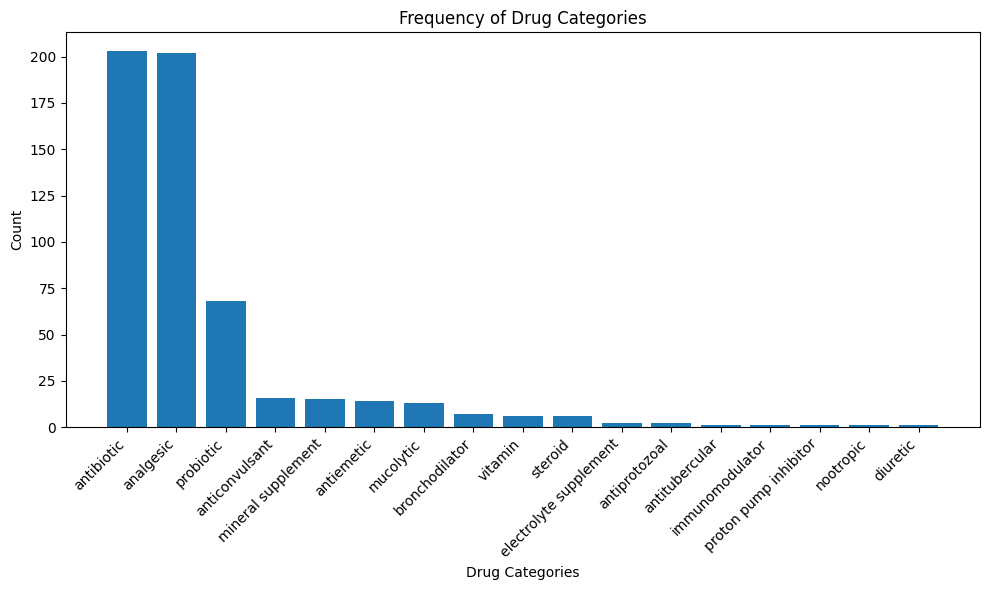

In [16]:
from collections import Counter

# Flatten the list of categories into a single list
category_counts = Counter(cat for categories in data['drug_category'] for cat in categories)

# Sort the categories by frequency
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)

# Separate the keys and values for plotting
categories, counts = zip(*sorted_categories)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, counts)
plt.xlabel('Drug Categories')
plt.ylabel('Count')
plt.title('Frequency of Drug Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


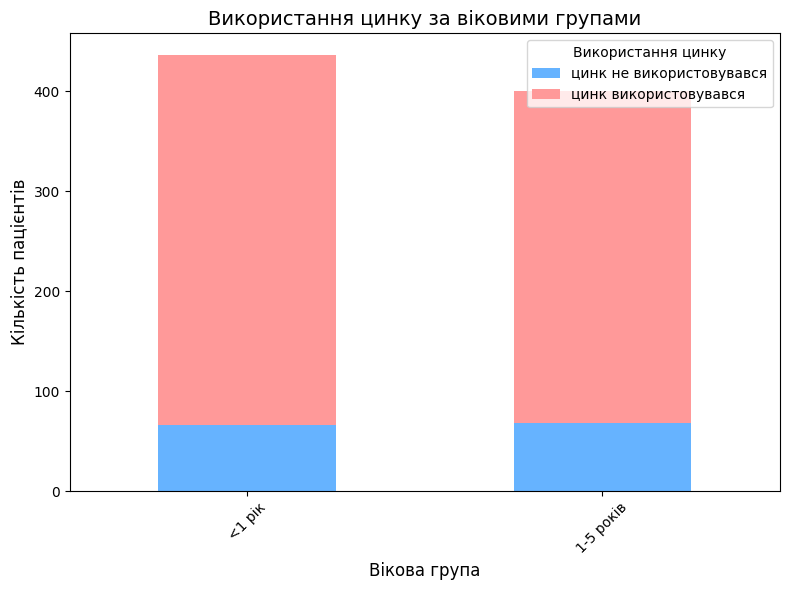

In [17]:
# Поєднання віку в одну змінну (наприклад, конвертувати місяці та дні в роки)
data['age_years'] = data['agey'] + data['agem'] / 12 + data['aged'] / 365

# Визначення вікових груп
bins = [0, 1, 5]  # Налаштуйте межі груп за потреби
labels = ['<1 рік', '1-5 років']
data['age_group'] = pd.cut(data['age_years'], bins=bins, labels=labels)

# Перехресна таблиця використання цинку за віковими групами
zinc_age = pd.crosstab(data['age_group'], data['zincfl'])

# Побудова графіка
zinc_age.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#66b3ff', '#ff9999'])

plt.xlabel('Вікова група', fontsize=12)
plt.ylabel('Кількість пацієнтів', fontsize=12)
plt.title('Використання цинку за віковими групами', fontsize=14)

# Зміна тексту в легенді
plt.legend(
    title='Використання цинку',
    labels=['цинк не використовувався', 'цинк використовувався'],
    loc='upper right'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



C:\Users\Danylo\AppData\Local\Temp\ipykernel_8140\1297690657.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Наявність ротавірусу', y='Кількість паієнтів', data=virus_status_counts, palette='coolwarm')


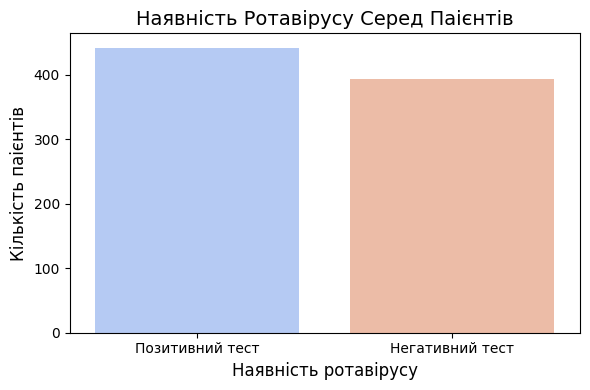

In [18]:

# Assuming 'data' is your DataFrame and 'virusfl' indicates rotavirus status

bar_plot = pd.DataFrame(data)

# If necessary, map the values to meaningful labels
# For example, if 'virusfl' contains 'Positive' and 'Negative', you can proceed directly
# If 'virusfl' contains codes like 1 for Positive and 0 for Negative, map them:
bar_plot['virusfl'] = bar_plot['virusfl'].map({1: 'Позитивний тест', 0: 'Негативний тест'})

# Count the number of patients in each category
virus_status_counts = bar_plot['virusfl'].value_counts().reset_index()
virus_status_counts.columns = ['Наявність ротавірусу', 'Кількість паієнтів']

# Plot the bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Наявність ротавірусу', y='Кількість паієнтів', data=virus_status_counts, palette='coolwarm')

# Add labels and title
plt.xlabel('Наявність ротавірусу', fontsize=12)
plt.ylabel('Кількість паієнтів', fontsize=12)
plt.title('Наявність Ротавірусу Серед Паієнтів', fontsize=14)
plt.tight_layout()
plt.show()


In [19]:
data.drop(['agey', 'agem', 'aged'], axis=1, inplace=True)

In [20]:
data.columns

Index(['subjid', 'sex', 'weight', 'height', 'vomitfl', 'vomit_minfrq',
       'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'orsfl', 'orstype',
       'inffl', 'inftype', 'zincfl', 'ztype', 'adrug', 'adrugtype', 'antibfl',
       'antibtype', 'hosp_days', 'drug_category', 'age_years', 'age_group'],
      dtype='object')

In [21]:
data['drug_category']

0                                           []
1                                           []
2                                           []
3                                  [analgesic]
4      [antibiotic, analgesic, anticonvulsant]
                        ...                   
835                                         []
836                                [probiotic]
837                                [probiotic]
838                                [probiotic]
839                                         []
Name: drug_category, Length: 836, dtype: object

In [22]:
# Extract unique categories from all entries in the 'drug_category' column
unique_categories = set(cat for categories in data['drug_category'] for cat in categories)

# Create a new column for each unique category
for category in unique_categories:
    column_name = f"{category}fl"
    # Assign 1 if the category is present in 'drug_category', otherwise 0
    data[column_name] = data['drug_category'].apply(lambda x: 1 if category in x else 0)

# Display the updated DataFrame
print(data.head())

# Save the updated dataset if needed
# data.to_csv('updated_data_with_flags.csv', index=False)


   subjid  sex  weight  height  vomitfl  vomit_minfrq  vomit_maxfrq  temp  \
0       1    2     4.9    60.0        1           2.0           3.0  37.8   
1       2    1     6.4    69.0        1           3.0           4.0  39.0   
2       3    1    13.0    82.0        0           NaN           NaN  37.1   
3       4    2     7.0    65.0        1           2.0           3.0  37.7   
4       5    1     8.3    68.0        0           NaN           NaN  36.9   

               dehsev  virusfl  ...  electrolyte supplementfl mucolyticfl  \
0  Severe dehydration        1  ...                         0           0   
1    Mild dehydration        1  ...                         0           0   
2    Mild dehydration        1  ...                         0           0   
3  Severe dehydration        1  ...                         0           0   
4    Mild dehydration        1  ...                         0           0   

   antiemeticfl nootropicfl  antitubercularfl immunomodulatorfl diureticfl

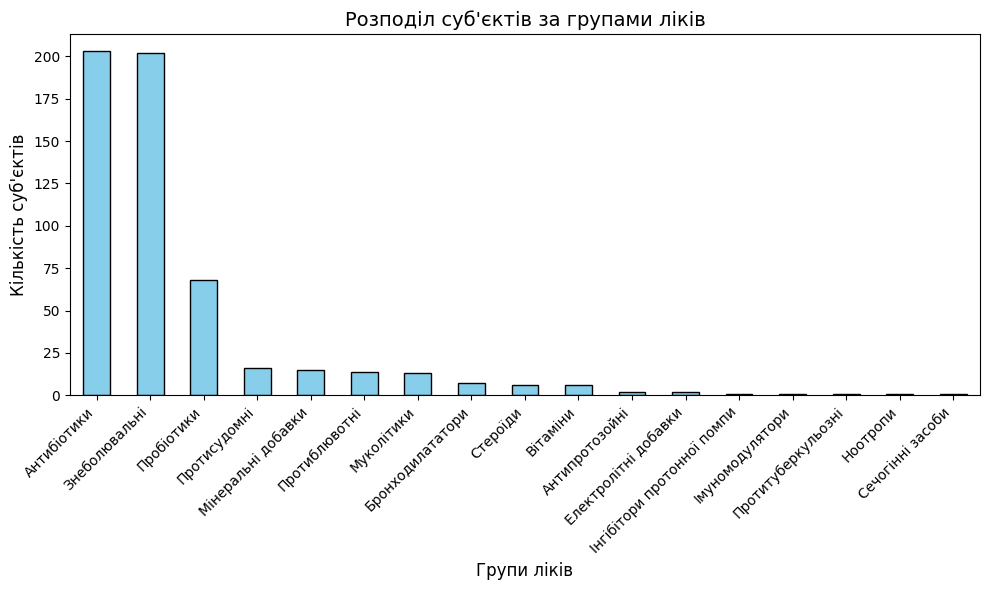

In [23]:
# Step 1: Identify drug-related columns ending with 'fl'
drug_group_columns = [col for col in data.columns if col.endswith('fl') and col not in ['zincfl', 'orsfl', 'vomitfl', 'virusfl', 'inffl', 'antibfl']]

# Step 2: Sum the values for each drug group across all rows
drug_group_counts = data[drug_group_columns].fillna(0).sum()

# Step 3: Translate column names to Ukrainian using the dictionary
label_translation = {
    'antibioticfl': 'Антибіотики',
    'analgesicfl': 'Знеболювальні',
    'probioticfl': 'Пробіотики',
    'anticonvulsantfl': 'Протисудомні',
    'mineral supplementfl': 'Мінеральні добавки',
    'antiemeticfl': 'Протиблювотні',
    'mucolyticfl': 'Муколітики',
    'bronchodilatorfl': 'Бронходилататори',
    'vitaminfl': 'Вітаміни',
    'steroidfl': 'Стероїди',
    'electrolyte supplementfl': 'Електролітні добавки',
    'antiprotozoalfl': 'Антипротозойні',
    'antitubercularfl': 'Протитуберкульозні',
    'nootropicfl': 'Ноотропи',
    'immunomodulatorfl': 'Імуномодулятори',
    'proton pump inhibitorfl': 'Інгібітори протонної помпи',
    'diureticfl': 'Сечогінні засоби'
}

# Step 4: Rename the index using the translation dictionary
drug_group_counts_ukr = drug_group_counts.rename(index=label_translation)

# Step 5: Plot the bar chart
plt.figure(figsize=(10, 6))
drug_group_counts_ukr.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Групи ліків', fontsize=12)
plt.ylabel('Кількість суб\'єктів', fontsize=12)
plt.title('Розподіл суб\'єктів за групами ліків', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


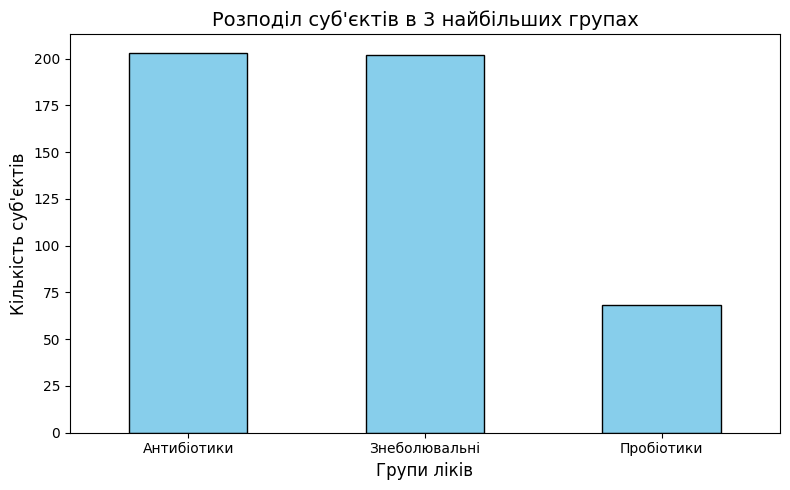

In [24]:
# Step 1: Identify drug-related columns ending with 'fl'
drug_group_columns = [col for col in data.columns if col.endswith('fl') and col not in ['zincfl', 'orsfl', 'vomitfl', 'virusfl', 'inffl', 'antibfl']]

# Step 2: Sum the values for each drug group across all rows
drug_group_counts = data[drug_group_columns].fillna(0).sum()

# Step 3: Select the top 3 drug groups
top_3_drug_groups = drug_group_counts.nlargest(3)

# Step 4: Translate column names to Ukrainian
label_translation = {
    'antibioticfl': 'Антибіотики',
    'analgesicfl': 'Знеболювальні',
    'probioticfl': 'Пробіотики'
}

# Rename the index using the translation dictionary
top_3_drug_groups_ukr = top_3_drug_groups.rename(index=label_translation)

# Step 5: Plot the bar chart for top 3 groups
plt.figure(figsize=(8, 5))
top_3_drug_groups_ukr.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Групи ліків', fontsize=12)
plt.ylabel('Кількість суб\'єктів', fontsize=12)
plt.title('Розподіл суб\'єктів в 3 найбільших групах', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [25]:
data.columns

Index(['subjid', 'sex', 'weight', 'height', 'vomitfl', 'vomit_minfrq',
       'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'orsfl', 'orstype',
       'inffl', 'inftype', 'zincfl', 'ztype', 'adrug', 'adrugtype', 'antibfl',
       'antibtype', 'hosp_days', 'drug_category', 'age_years', 'age_group',
       'antibioticfl', 'anticonvulsantfl', 'probioticfl', 'steroidfl',
       'antiprotozoalfl', 'vitaminfl', 'proton pump inhibitorfl',
       'electrolyte supplementfl', 'mucolyticfl', 'antiemeticfl',
       'nootropicfl', 'antitubercularfl', 'immunomodulatorfl', 'diureticfl',
       'bronchodilatorfl', 'mineral supplementfl', 'analgesicfl'],
      dtype='object')

In [26]:
# List of columns to drop
columns_to_drop = [
    'orsfl', 'orstype', 'antitubercularfl', 'electrolyte supplementfl',
    'anticonvulsantfl', 'antiprotozoalfl', 'steroidfl',
    'proton pump inhibitorfl', 'immunomodulatorfl', 'nootropicfl',
    'mineral supplementfl', 'antiemeticfl', 'diureticfl',
     'mucolyticfl', 'bronchodilatorfl', 'vitaminfl', 'drug_category','adrug'
]

# Drop the specified columns
data.drop(columns_to_drop, axis=1, inplace=True)

# Check the remaining columns
print(data.columns)


Index(['subjid', 'sex', 'weight', 'height', 'vomitfl', 'vomit_minfrq',
       'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'inffl', 'inftype',
       'zincfl', 'ztype', 'adrugtype', 'antibfl', 'antibtype', 'hosp_days',
       'age_years', 'age_group', 'antibioticfl', 'probioticfl', 'analgesicfl'],
      dtype='object')


In [27]:
print(data.columns)


Index(['subjid', 'sex', 'weight', 'height', 'vomitfl', 'vomit_minfrq',
       'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'inffl', 'inftype',
       'zincfl', 'ztype', 'adrugtype', 'antibfl', 'antibtype', 'hosp_days',
       'age_years', 'age_group', 'antibioticfl', 'probioticfl', 'analgesicfl'],
      dtype='object')


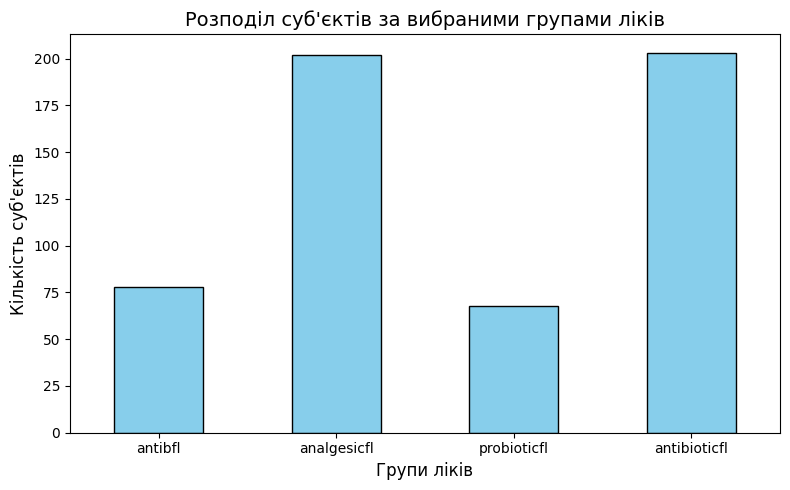

In [28]:
# List of columns to plot
columns_to_plot = ['antibfl', 'analgesicfl', 'probioticfl', 'antibioticfl']

# Sum the values for these columns across all rows
data_subset = data[columns_to_plot].fillna(0).sum()

# Plot the bar chart
plt.figure(figsize=(8, 5))
data_subset.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Групи ліків', fontsize=12)
plt.ylabel('Кількість суб\'єктів', fontsize=12)
plt.title('Розподіл суб\'єктів за вибраними групами ліків', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


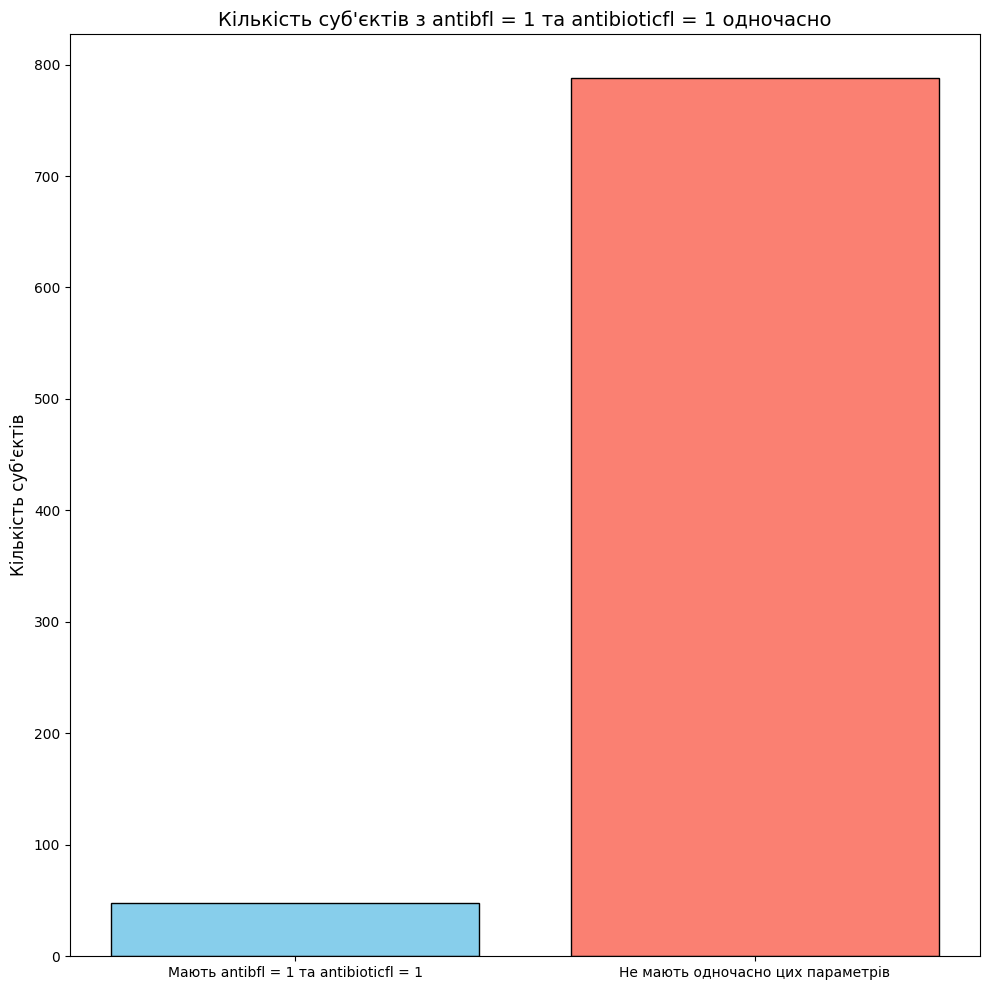

In [29]:
# Загальна кількість суб'єктів
total_subjects = len(data)

# Кількість суб'єктів, де одночасно antibfl = 1 та antibioticfl = 1
subjects_with_both = len(data[(data['antibfl'] == 1) & (data['antibioticfl'] == 1)])

# Формування даних для графіка
counts = {
    'Мають antibfl = 1 та antibioticfl = 1': subjects_with_both,
    'Не мають одночасно цих параметрів': total_subjects - subjects_with_both
}

# Побудова графіка
plt.figure(figsize=(10, 10))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Кількість суб\'єктів з antibfl = 1 та antibioticfl = 1 одночасно', fontsize=14)
plt.ylabel('Кількість суб\'єктів', fontsize=12)
plt.tight_layout()
plt.show()


In [30]:
# Фільтрація суб'єктів, у яких одночасно antibfl = 1 та antibioticfl = 1
subjects_to_remove = data[(data['antibfl'] == 1) & (data['antibioticfl'] == 1)]

# Кількість таких суб'єктів
num_subjects_to_remove = len(subjects_to_remove)
print(f"Кількість суб'єктів, які будуть видалені: {num_subjects_to_remove}")

# Видалення цих суб'єктів з датасету
data = data[~((data['antibfl'] == 1) & (data['antibioticfl'] == 1))]

# Підтвердження, що суб'єкти були видалені
print(f"Кількість суб'єктів після видалення: {len(data)}")


Кількість суб'єктів, які будуть видалені: 48
Кількість суб'єктів після видалення: 788


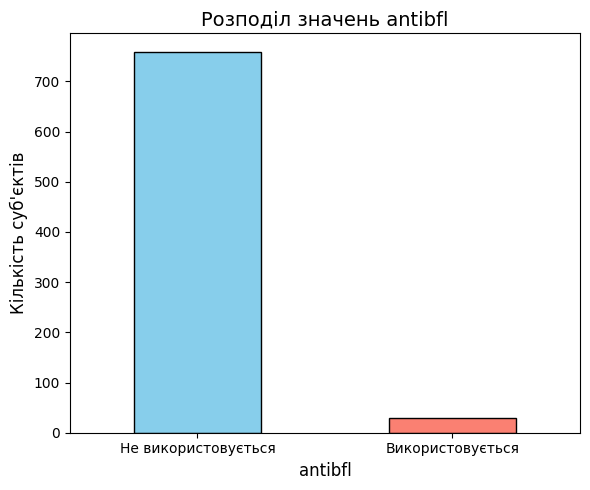

In [31]:
# Count the occurrences of each value in antibfl
antibfl_counts = data['antibfl'].value_counts()

# Rename the index for better labels
antibfl_counts.index = ['Не використовується', 'Використовується']

# Plot the bar chart
plt.figure(figsize=(6, 5))
antibfl_counts.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('antibfl', fontsize=12)
plt.ylabel('Кількість суб\'єктів', fontsize=12)
plt.title('Розподіл значень antibfl', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [32]:
# Filter rows where antibfl = 1
subjects_to_remove = data[data['antibfl'] == 1]

# Count the number of subjects to be removed
num_subjects_to_remove = len(subjects_to_remove)
print(f"Кількість суб'єктів, які будуть видалені (antibfl = 1): {num_subjects_to_remove}")

# Remove rows where antibfl = 1
data = data[data['antibfl'] != 1]

# Output the remaining number of subjects
print(f"Кількість суб'єктів після видалення (antibfl = 1): {len(data)}")


Кількість суб'єктів, які будуть видалені (antibfl = 1): 30
Кількість суб'єктів після видалення (antibfl = 1): 758


In [33]:
# List of columns to drop
columns_to_drop = [
    'antibfl'
]

# Drop the specified columns
data.drop(columns_to_drop, axis=1, inplace=True)

# Check the remaining columns
print(data.columns)


Index(['subjid', 'sex', 'weight', 'height', 'vomitfl', 'vomit_minfrq',
       'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'inffl', 'inftype',
       'zincfl', 'ztype', 'adrugtype', 'antibtype', 'hosp_days', 'age_years',
       'age_group', 'antibioticfl', 'probioticfl', 'analgesicfl'],
      dtype='object')


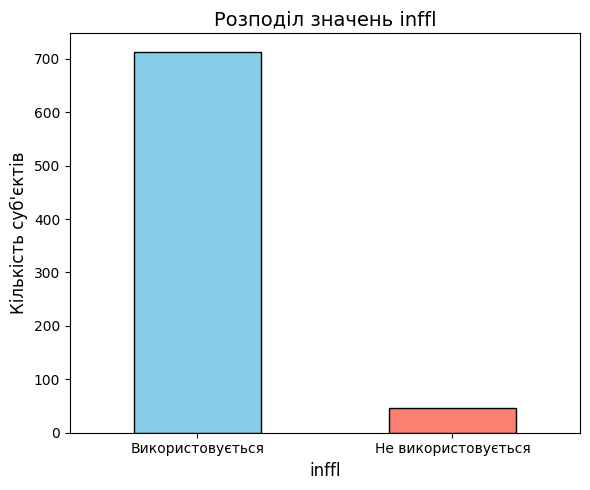

In [34]:
# Count the occurrences of each value in inffl
inffl_counts = data['inffl'].value_counts()

# Rename the index for better labels
inffl_counts.index = ['Використовується' , 'Не використовується']

# Plot the bar chart
plt.figure(figsize=(6, 5))
inffl_counts.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('inffl', fontsize=12)
plt.ylabel('Кількість суб\'єктів', fontsize=12)
plt.title('Розподіл значень inffl', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [35]:
# Filter rows where inffl = 1
subjects_to_remove = data[data['inffl'] == 0]

# Count the number of subjects to be removed
num_subjects_to_remove = len(subjects_to_remove)
print(f"Кількість суб'єктів, які будуть видалені (inffl = 1): {num_subjects_to_remove}")

# Remove rows where inffl = 1
data = data[data['inffl'] == 1]

# Output the remaining number of subjects
print(f"Кількість суб'єктів після видалення (inffl = 1): {len(data)}")


Кількість суб'єктів, які будуть видалені (inffl = 1): 46
Кількість суб'єктів після видалення (inffl = 1): 712


In [36]:
# List of columns to drop
columns_to_drop = [
    'inffl', 'inftype'
]

# Drop the specified columns
data.drop(columns_to_drop, axis=1, inplace=True)

# Check the remaining columns
print(data.columns)


Index(['subjid', 'sex', 'weight', 'height', 'vomitfl', 'vomit_minfrq',
       'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'zincfl', 'ztype',
       'adrugtype', 'antibtype', 'hosp_days', 'age_years', 'age_group',
       'antibioticfl', 'probioticfl', 'analgesicfl'],
      dtype='object')


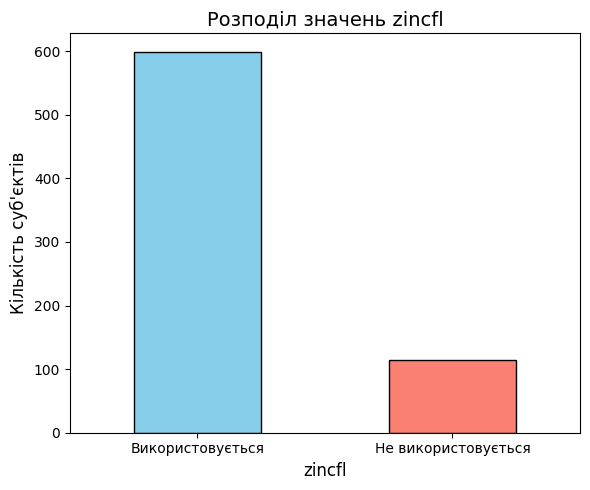

In [37]:
# Count the occurrences of each value in zincfl
zincfl_counts = data['zincfl'].value_counts()

# Rename the index for better labels
zincfl_counts.index = ['Використовується',  'Не використовується']

# Plot the bar chart
plt.figure(figsize=(6, 5))
zincfl_counts.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('zincfl', fontsize=12)
plt.ylabel('Кількість суб\'єктів', fontsize=12)
plt.title('Розподіл значень zincfl', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [38]:
# Filter rows where zincfl = 1
subjects_to_remove = data[data['zincfl'] == 0]

# # Count the number of subjects to be removed
num_subjects_to_remove = len(subjects_to_remove)
print(f"Кількість суб'єктів, які будуть видалені (zincfl = 1): {num_subjects_to_remove}")

# # Remove rows where zincfl = 1
data = data[data['zincfl'] == 1]

# # Output the remaining number of subjects
print(f"Кількість суб\'єктів після видалення (zincfl = 1): {len(data)}")


Кількість суб'єктів, які будуть видалені (zincfl = 1): 114
Кількість суб'єктів після видалення (zincfl = 1): 598


In [39]:
# List of columns to drop
columns_to_drop = [
    'zincfl', 'ztype','age_group', 'adrugtype', 'antibtype'
]

# Drop the specified columns
data.drop(columns_to_drop, axis=1, inplace=True)



In [40]:
print(data.columns)

Index(['subjid', 'sex', 'weight', 'height', 'vomitfl', 'vomit_minfrq',
       'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'hosp_days', 'age_years',
       'antibioticfl', 'probioticfl', 'analgesicfl'],
      dtype='object')


In [41]:
'sex', 'weight', 'height', 'age_years'

('sex', 'weight', 'height', 'age_years')

In [42]:
# Display the first few rows of the data
print(data[['sex', 'weight', 'height', 'age_years']].head())

# Summary statistics for numerical variables
print(data[['weight', 'height', 'age_years']].describe())

# Count of each category in 'sex'
print(data['sex'].value_counts())


   sex  weight  height  age_years
0    2     4.9    60.0   0.393607
1    1     6.4    69.0   1.893607
2    1    13.0    82.0   1.868950
3    2     7.0    65.0   0.657306
5    1     5.6    71.0   0.885388
           weight      height   age_years
count  598.000000  598.000000  598.000000
mean     8.711538   74.921906    1.237665
std      2.604837   12.697400    0.862449
min      2.500000   46.000000    0.038356
25%      7.200000   67.000000    0.666667
50%      8.300000   73.000000    1.000000
75%     10.000000   82.150000    1.612100
max     21.500000  127.000000    4.815753
sex
1    362
2    236
Name: count, dtype: int64


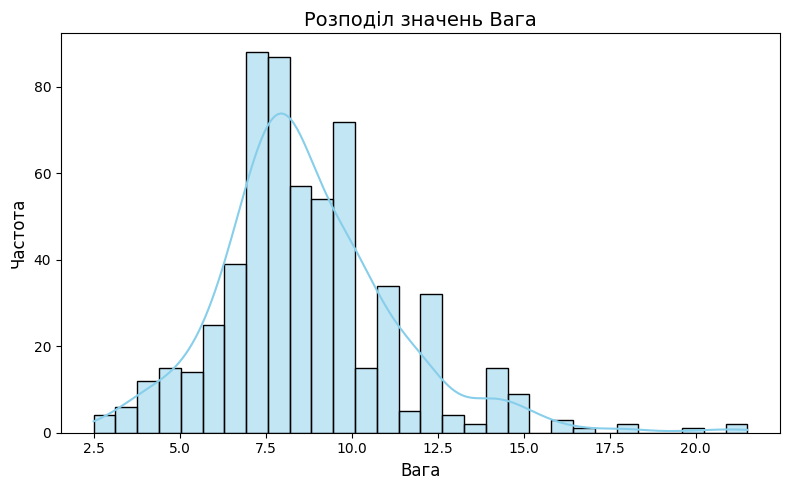

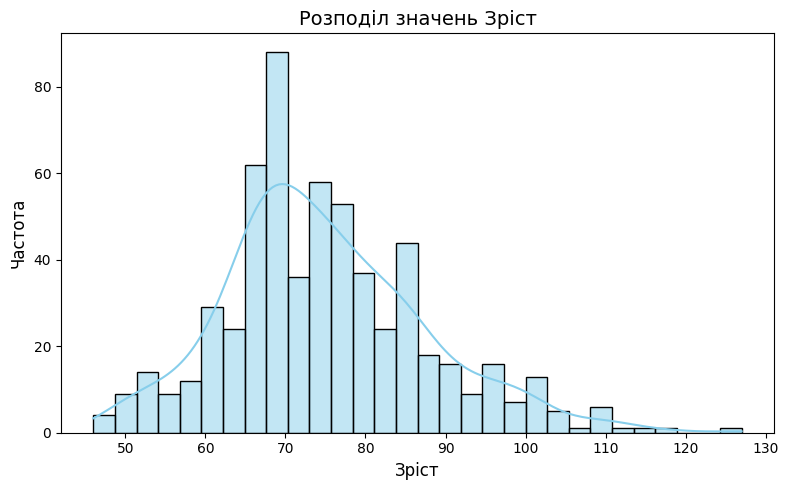

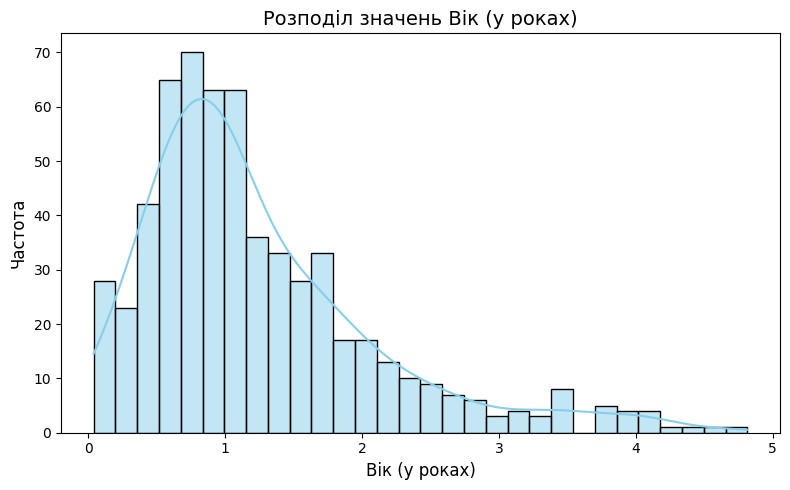

In [43]:
# Ukrainian translations for column names
column_translation = {
    'weight': 'Вага',
    'height': 'Зріст',
    'age_years': 'Вік (у роках)',
}

# Plot distributions with Ukrainian titles
for col in ['weight', 'height', 'age_years']:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Розподіл значень {column_translation.get(col, col)}', fontsize=14)
    plt.xlabel(column_translation.get(col, col), fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.tight_layout()
    plt.show()


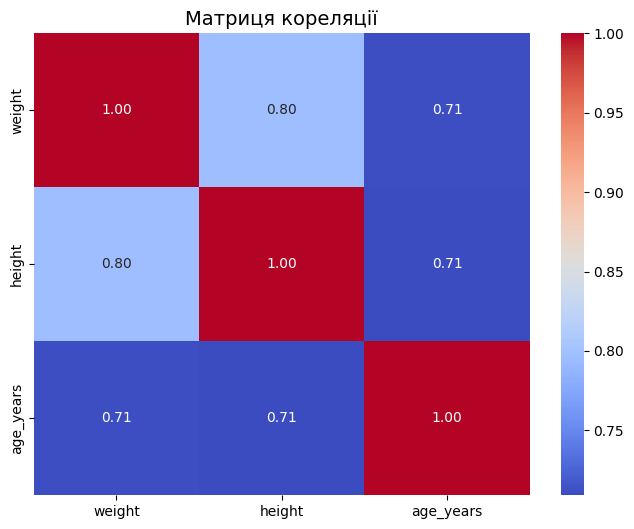

In [44]:
# Compute the correlation matrix
correlation_matrix = data[['weight', 'height', 'age_years']].corr()

# Display the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матриця кореляції', fontsize=14)
plt.show()


In [45]:
# Assuming 'df' is your DataFrame containing the data
import pandas as pd

# Create a combination code for each patient
data['treatment_combination'] = data['antibioticfl'].astype(str) + data['probioticfl'].astype(str) + data['analgesicfl'].astype(str)

# Map the combination code to a description
combination_mapping = {
    '000': 'No treatments',
    '100': 'Antibiotic only',
    '010': 'Probiotic only',
    '001': 'Analgesic only',
    '110': 'Antibiotic and Probiotic',
    '101': 'Antibiotic and Analgesic',
    '011': 'Probiotic and Analgesic',
    '111': 'All three treatments'
}

data['combination_description'] = data['treatment_combination'].map(combination_mapping)

# Calculate counts for each combination
combination_counts = data['combination_description'].value_counts().reset_index()
combination_counts.columns = ['Treatment Combination', 'Count']

# Display the counts
print(combination_counts)


      Treatment Combination  Count
0             No treatments    363
1            Analgesic only     96
2           Antibiotic only     57
3            Probiotic only     32
4  Antibiotic and Analgesic     32
5   Probiotic and Analgesic     12
6      All three treatments      4
7  Antibiotic and Probiotic      2


In [46]:

# Display unique values in 'dehsev'
print("Unique values in 'dehsev':")
print(data['dehsev'].unique())

# Clean 'dehsev' by stripping whitespace
data['dehsev'] = data['dehsev'].str.strip()

# One-hot encode 'dehsev'
data = pd.get_dummies(data, columns=['dehsev'], prefix='dehsev', drop_first=False)


Unique values in 'dehsev':
['Severe dehydration' 'Mild dehydration' 'No dehydration']


                subjid       sex    weight    height   vomitfl  vomit_minfrq  \
subjid        1.000000  0.090310  0.013602 -0.034310  0.008648     -0.030739   
sex           0.090310  1.000000 -0.105588 -0.045594  0.013649      0.084533   
weight        0.013602 -0.105588  1.000000  0.796013  0.144498      0.091437   
height       -0.034310 -0.045594  0.796013  1.000000  0.177126      0.086779   
vomitfl       0.008648  0.013649  0.144498  0.177126  1.000000     -0.028208   
vomit_minfrq -0.030739  0.084533  0.091437  0.086779 -0.028208      1.000000   
vomit_maxfrq  0.047896  0.096550  0.148030  0.124454 -0.007013      0.801296   
temp         -0.050789 -0.026523 -0.118303 -0.115950 -0.051471      0.018134   
virusfl       0.003857 -0.041581 -0.024101 -0.040423  0.155215      0.057257   
hosp_days     0.223868  0.029896 -0.075875 -0.069576 -0.155560      0.036589   
age_years     0.012042  0.008911  0.710303  0.709101  0.085073      0.086302   
antibioticfl  0.186365  0.023477 -0.0803

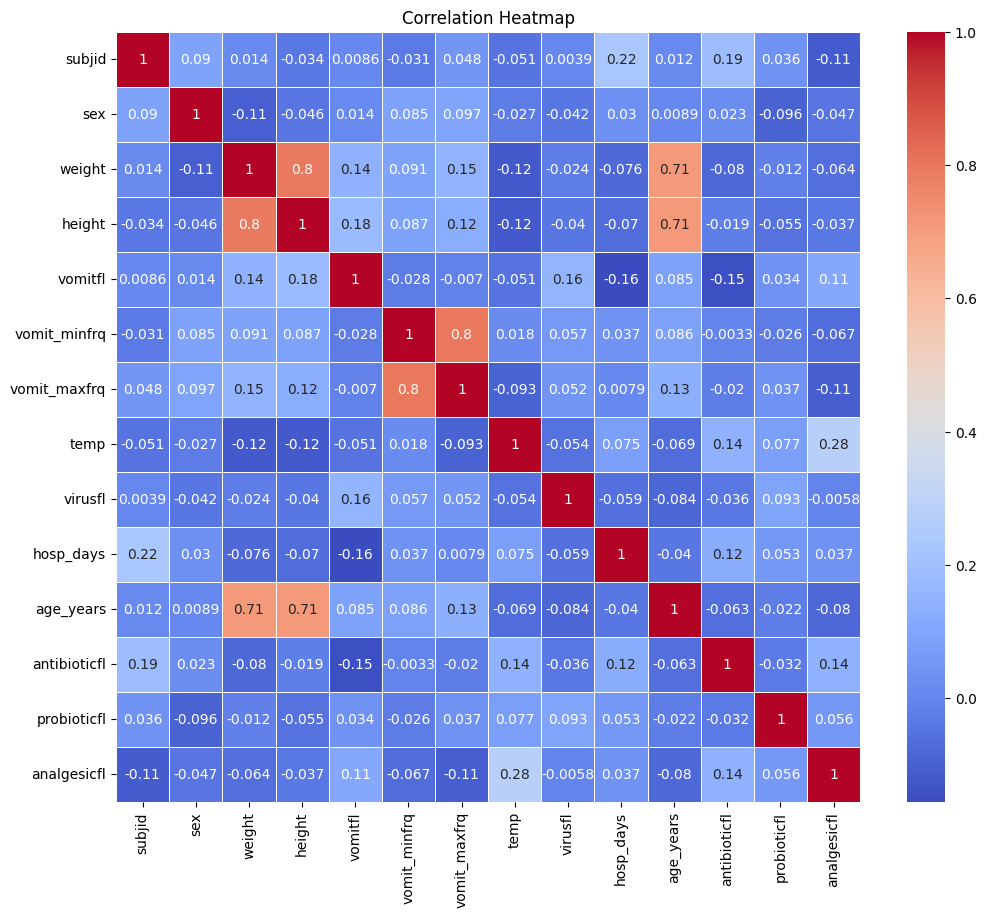

In [47]:
# Drop non-numeric columns for correlation analysis
numeric_df = data.select_dtypes(include=['number'])

# Check correlations between numeric features to identify multicollinearity
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot a heatmap of the correlation matrix for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

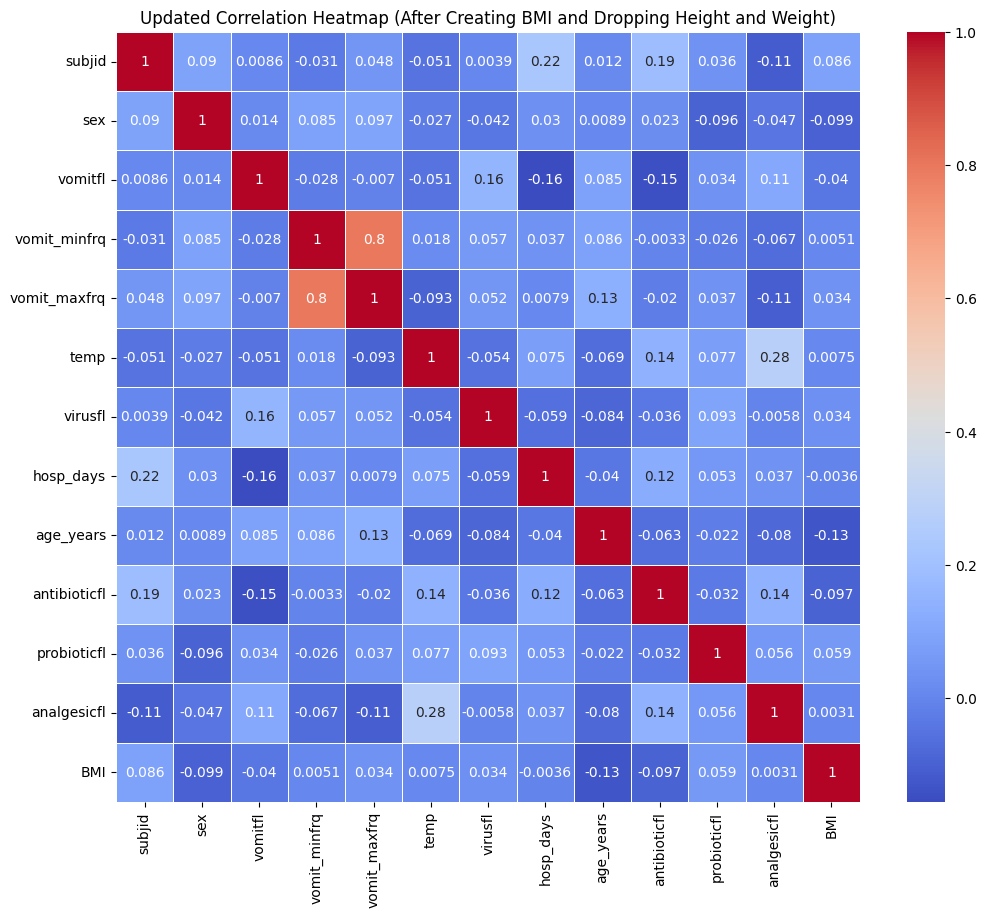

In [48]:
# Load the dataset (assuming it's already loaded as 'df')

# Step 1: Create BMI (assuming weight in kg and height in cm)
data['BMI'] = data['weight'] / (data['height'] / 100) ** 2

# Step 2: Drop height and weight columns since BMI is now included
data = data.drop(columns=['height', 'weight'])

# Step 3: Drop non-numeric columns for correlation analysis
numeric_df = data.select_dtypes(include=['number'])

# Step 4: Check correlations again after creating BMI and dropping height and weight
correlation_matrix = numeric_df.corr()

# Step 5: Plot a heatmap of the updated correlation matrix for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Updated Correlation Heatmap (After Creating BMI and Dropping Height and Weight)')
plt.show()


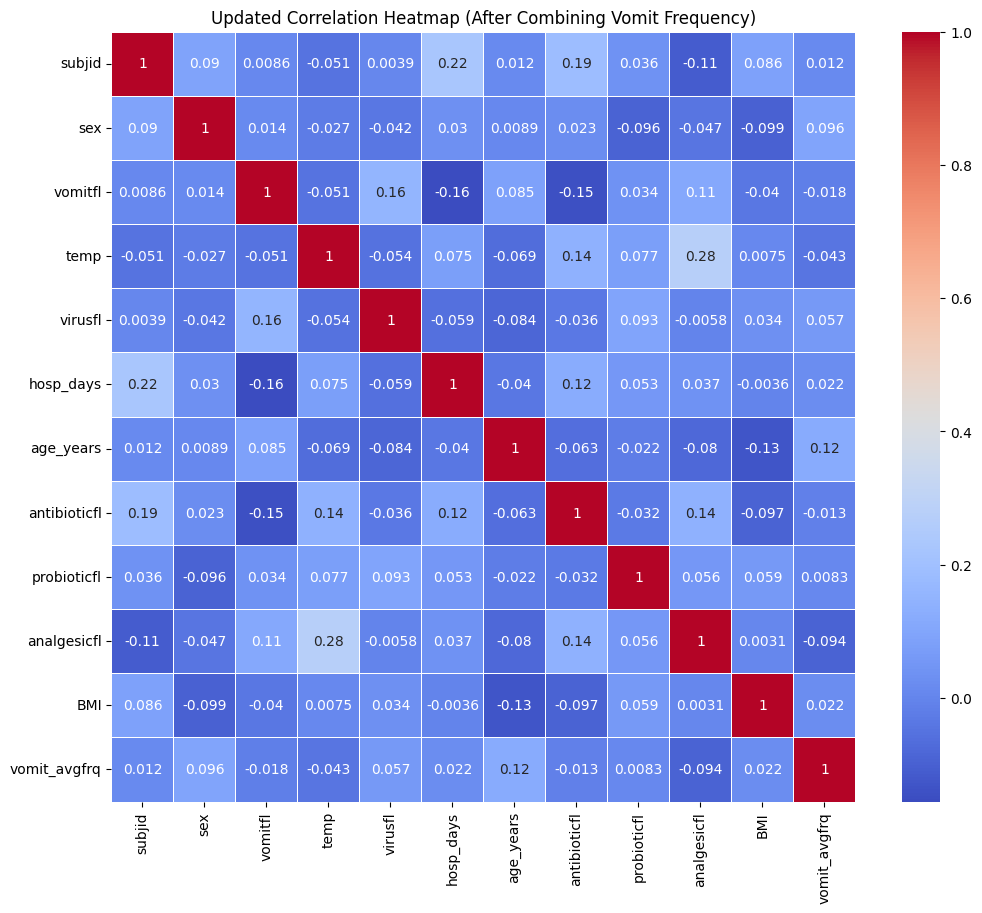

In [49]:
# Create a new feature for the average vomiting frequency
data['vomit_avgfrq'] = data[['vomit_minfrq', 'vomit_maxfrq']].mean(axis=1)

# Drop the original vomit_minfrq and vomit_maxfrq columns to reduce redundancy
data = data.drop(columns=['vomit_minfrq', 'vomit_maxfrq'])

# Drop non-numeric columns for correlation analysis
numeric_df = data.select_dtypes(include=['number'])

# Check correlations again after creating vomit_avgfrq and dropping vomit_minfrq and vomit_maxfrq
correlation_matrix = numeric_df.corr()

# Plot a heatmap of the updated correlation matrix for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Updated Correlation Heatmap (After Combining Vomit Frequency)')
plt.show()

In [50]:
import os
# Define the path to the data folder
data_folder = os.path.join(os.getcwd(), 'data')
file_path = os.path.join(data_folder, 'saved_data.csv')

# Save the DataFrame as a CSV file
data.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")

DataFrame saved to c:\Users\Danylo\Desktop\MainCategories\MastersDiploma\Practice\program\src\data\saved_data.csv
